In [190]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [191]:
Cg = 1.78
eps = 1e-5
laplace_scale = 1.0 / (2**.5)

## Helper Functions

In [216]:
def randomNumberGenerator(n,A,gamma=(2*Cg)**.5):
    """Draws random numbers from Normal, Laplace and Cauchy distributions."""
    distributions = {}
    distributions['Normal'] = A + np.random.randn(n)
    distributions['Laplace'] = A + np.random.laplace(size = n,scale = laplace_scale)
    distributions['Cauchy'] = A + scipy.stats.cauchy.rvs(size=n,loc = 0, scale = gamma)
    return distributions

def f(data,gamma,A):
    """Optimization function for the Cauchy distribution (given gamma)."""
    return np.sum((A-data)/(1 + ((data-A)/gamma)**2))

def df_dA(data,gamma,A):
    """Derivative of f with respect to A."""
    return (f(data,gamma,A+eps) - f(data,gamma,A-eps))/(2*eps)

def nr(data,guess,gamma,iterations=1000):
    """Newton-Raphson method for estimating the scale parameter of a Cauchy distribution."""
    for iteration in range(iterations):
        y = f(data,gamma, guess)
        dy_dA = df_dA(data, gamma, guess)
        guess -= y/dy_dA
        if abs(y) < eps:
            break
    return guess

def MLEestimates(distributions, gamma, guess):
    """Calculates the MLE estimates for Normal, Laplace and Cauchy distributions."""
    estimates = {}
    for key in distributions.keys():
        if key == 'Normal':
            estimates[key] = np.mean(distributions[key])
        elif key == 'Laplace':
            estimates[key] = np.median(distributions[key])
        elif key == 'Cauchy':
            estimates[key] = nr(distributions[key], guess, gamma=gamma,iterations=10000)
    return estimates

## Experiments

In [ ]:
def realisations(N,A,num_realisations, guess):
    """Generates random numbers and calculates MLE estimates for multiple realisations."""
    estimates = {"Normal": [], "Laplace": [], "Cauchy": []}
    for i in range(num_realisations):
        distributions = randomNumberGenerator(N,A)
        estimate = MLEestimates(distributions, gamma=(2*Cg)**.5, guess=guess)
        for key in estimate.keys():
            estimates[key].append(estimate[key])
    return estimates

def getStatistics(estimates):
    """Calculates mean and standard deviation of MLE estimates."""
    statistics = {}
    # axs = fig.subplots(1, 3, sharex=True, sharey=True)
    for i,key in enumerate(estimates.keys()):
        # if show:
        #     fig = plt.figure(figsize=(5, 5), layout="constrained")
        statistics[key] = {
            'mean': np.mean(estimates[key]),
            'var': np.var(estimates[key])
        }
    #     if show:
    #         plt.subplot(3, 1, i+1)
    #         plotCDFs(estimates[key], label=key, stat=statistics[key], color='blue')
    #     # plt.hist(estimates[key], cumulative=True, label='CDF',histtype='step', alpha=0.8, color='k',range=(-20,20), bins=30)
    # plt.show()
    return statistics

def iterateOverNs(N,A, num_realisations, guess):
    """Iterates over different sample sizes and calculates MLE estimates."""
    estimates = {}
    stats = {}
    for n in N:
        # print(f"Sample size: {n}")
        estimates[n] = realisations(n,A,num_realisations, guess=guess)
        stats[n] = getStatistics(estimates[n])
    return estimates, stats


## Plotting functions

In [232]:
def plotCDFs(data, stat ,label='CDF', color='blue', axis=None):
    """Plots the CDF of the data."""
    if axis is None:
        fig, axis = plt.subplots(figsize=(5, 5), layout="constrained")
    sorted_data = np.sort(data)
    cdf = np.linspace(0, 1, len(sorted_data))
    axis.step(sorted_data, cdf, where='post', label=label, color=color)
    axis.set_xlabel('Value of $\hat{A}$')
    axis.set_ylabel('Cumulative Probability')
    axis.set_title(f"CDF of {label} with mean: {stat['mean']:.3E} var: {stat['var']:.3E}")
    axis.set_xlim(max(-2,np.min(data)), min(4,np.max(data)))
    # plt.legend()
    # plt.show()

def plotCDFsAndPDFs(N,estimates,stats):
    for n in N:
        fig, axs = plt.subplots(3, 2, figsize=(10, 5), layout="constrained")
        for i,key in enumerate(estimates[n].keys()):
            axs[i,0].hist(estimates[n][key], density=True, bins=100, alpha=0.5, color='blue', label='PDF',range=(max(-2,np.min(estimates[n][key])), min(4,np.max(estimates[n][key]))))
            axs[i,0].set_title(f"PDF of {key} with sample size {n}")
            plotCDFs(estimates[n][key], stats[n][key], label=key, color='blue', axis=axs[i,1])
            axs[i,1].set_title(f"CDF of {key} with sample size {n}")
        plt.show()

def plotMeanAndVar(stats):
    N = stats.keys()
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
    mean, var = {"Normal": [], "Laplace": []},{"Normal": [], "Laplace": []}
    for n in stats.keys():
        for key in mean.keys():
            mean[key].append(stats[n][key]['mean'])
            var[key].append(stats[n][key]['var'])
    for key in mean.keys():
        axs[0].plot(N, mean[key], label=key)
        axs[1].plot(N, var[key], label=key)
    axs[0].set_xlabel('Sample Size')
    axs[0].set_ylabel('Mean of $\hat{A}$')
    axs[0].set_title('Mean of $\hat{A}$')
    axs[0].set_xscale('log')
    axs[1].set_xlabel('Sample Size')
    axs[1].set_ylabel('Variance of $\hat{A}$')
    axs[1].set_title('Variance of $\hat{A}$')
    axs[1].set_xscale('log')
    axs[0].legend()
    axs[1].legend()
    plt.show()

In [230]:
stats1

{1: {'Normal': {'mean': 0.951255806532505, 'var': 1.045578956087998},
  'Laplace': {'mean': 0.9917624859430572, 'var': 0.9612030855577754},
  'Cauchy': {'mean': 3958.5535629971855, 'var': 791123816114.2004}},
 10: {'Normal': {'mean': 0.9772611046892803, 'var': 0.10267512321670014},
  'Laplace': {'mean': 0.9980898752639387, 'var': 0.07508234707223561},
  'Cauchy': {'mean': 40736.199997504846, 'var': 5558793811025.654}},
 100: {'Normal': {'mean': 0.9967898949490557, 'var': 0.00940925022606394},
  'Laplace': {'mean': 1.0024824346670942, 'var': 0.005493650241405625},
  'Cauchy': {'mean': 0.9939527652206108, 'var': 0.07484580016622337}},
 1000: {'Normal': {'mean': 0.9993242962688521, 'var': 0.0009812775647946295},
  'Laplace': {'mean': 0.9987540526904337, 'var': 0.0005471905442106977},
  'Cauchy': {'mean': 0.9986612949607575, 'var': 0.00692536620960869}},
 10000: {'Normal': {'mean': 0.9993472876747673, 'var': 9.916189272145485e-05},
  'Laplace': {'mean': 0.9994512495951805, 'var': 5.1069499

In [226]:
N = [1, 10, 100, 1000, 10000]
A = 1.0
num_realisations = 1000
estimates1, stats1 = iterateOverNs(N,A,num_realisations,guess=1.0)
A = 10.0
estimates10, stats10 = iterateOverNs(N,A,num_realisations,guess=10.0)

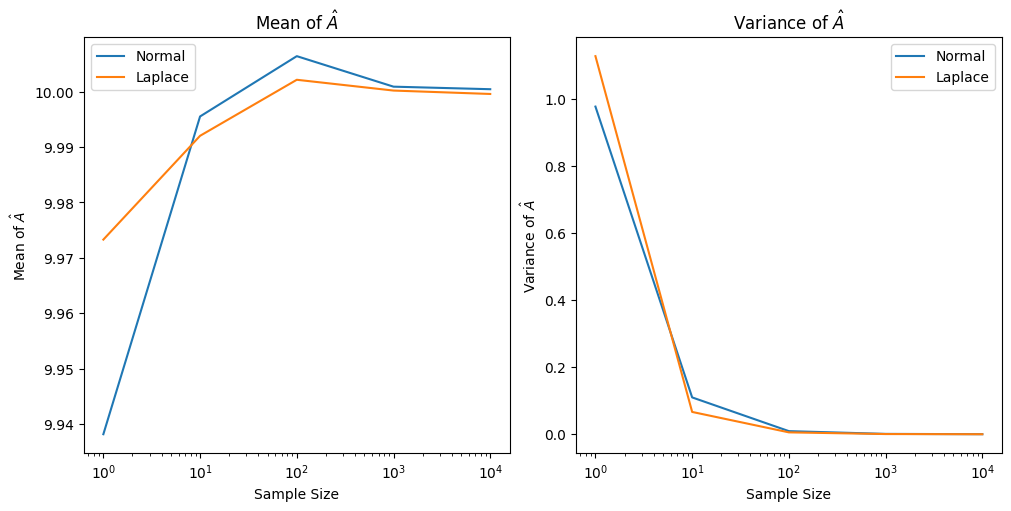

In [234]:
plotMeanAndVar(stats10)

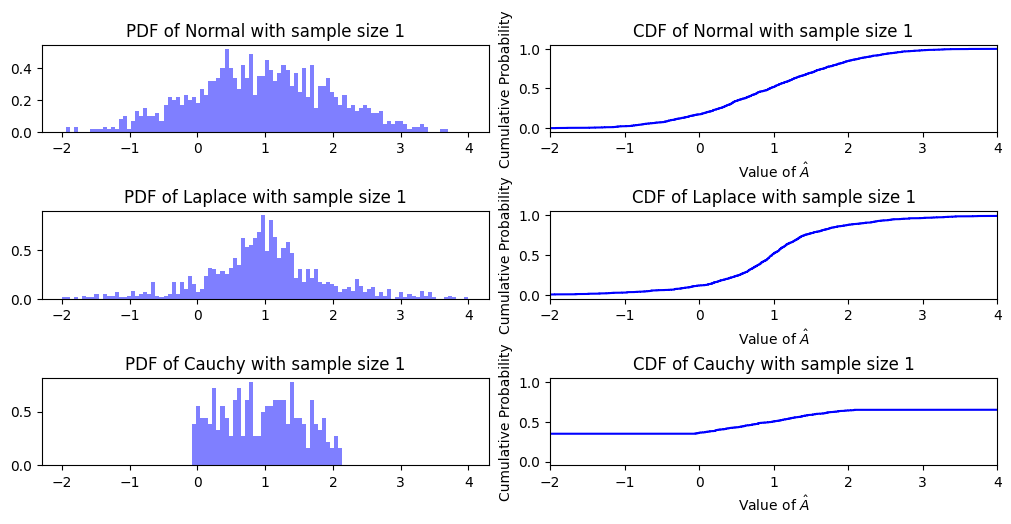

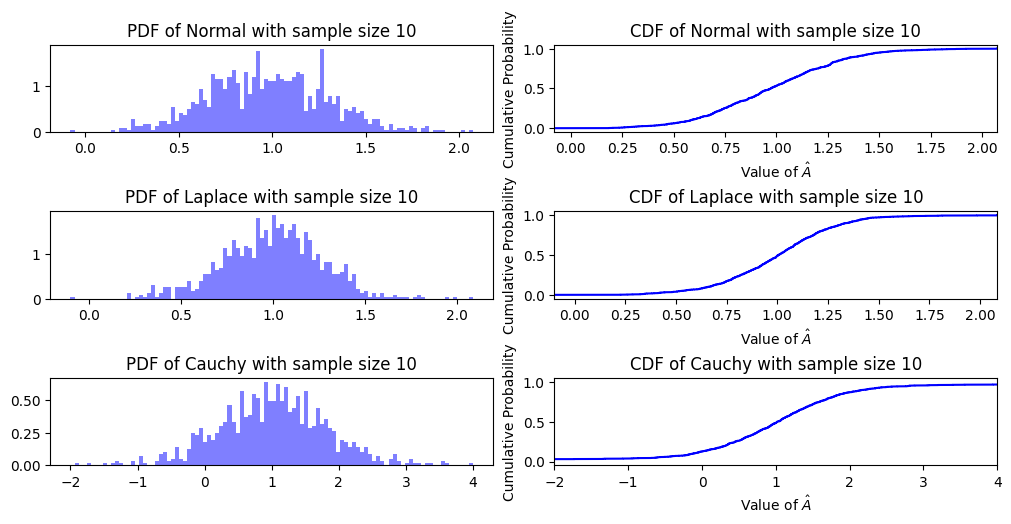

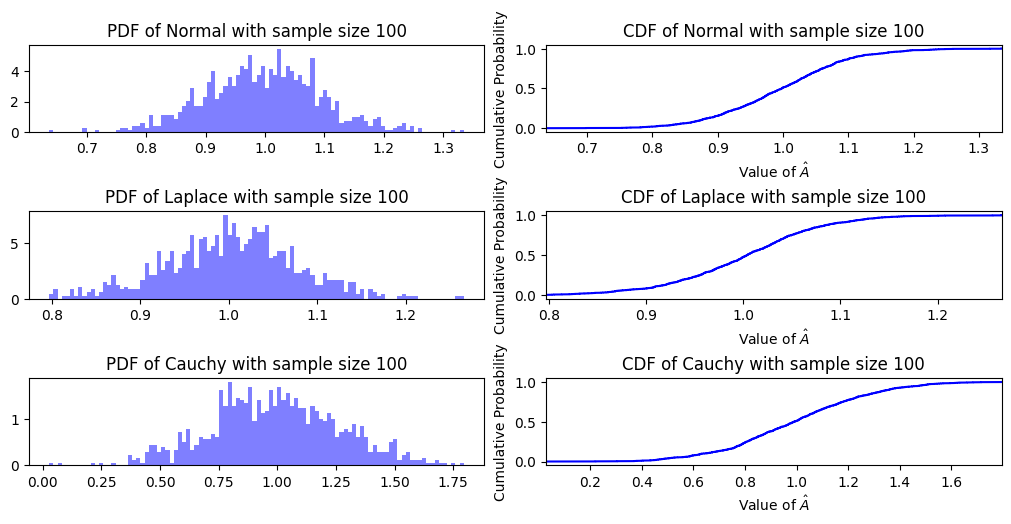

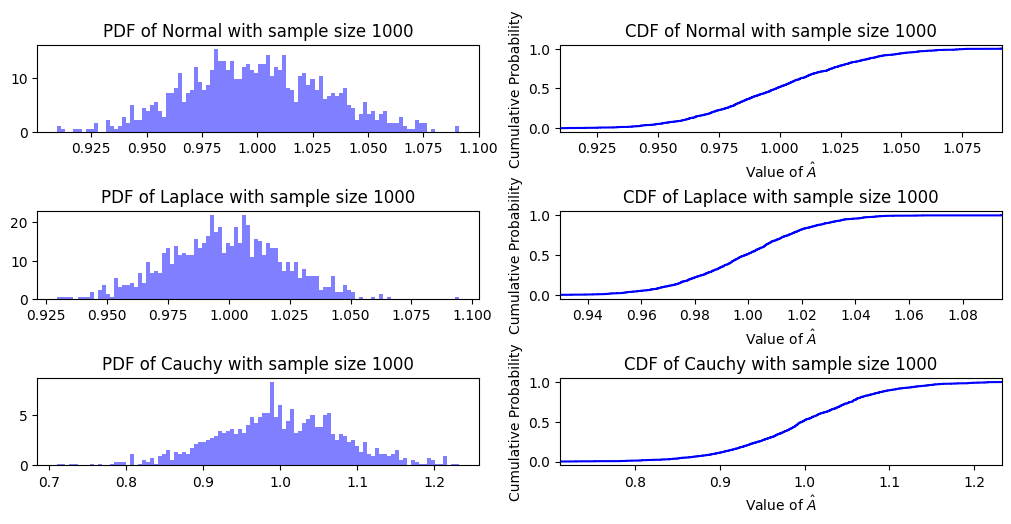

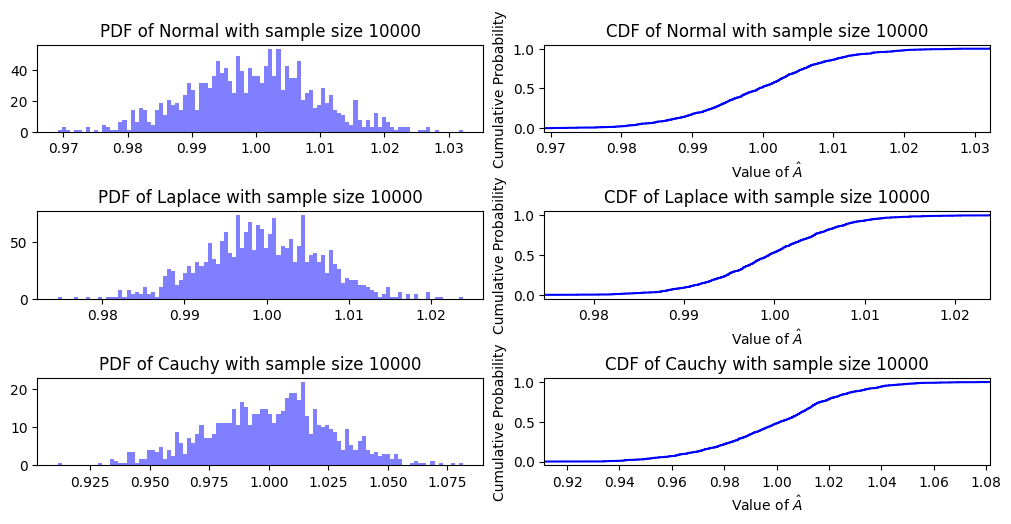

In [229]:
plotCDFsAndPDFs(N, estimates1, stats1)

In [ ]:
n = 100
A = 1
estimates = realisations(n, A, 1000)
# distributions = randomNumberGenerator(n, A=1, gamma = (2*Cg)**.5)
# estimates = MLEestimates(distributions, gamma=(2*Cg)**.5)
# print(estimates)

In [ ]:
np.mean(estimates['Cauchy'])

-36921.4750422405

In [ ]:
np.mean(estimates['Cauchy'])

-36921.4750422405

In [ ]:
stats = getStatistics(estimates=estimates)

In [ ]:
min(distributions['Cauchy'])

NameError: name 'distributions' is not defined

In [ ]:
hist,bins =  np.histogram(distributions['Normal'], bins=500)

<BarContainer object of 500 artists>

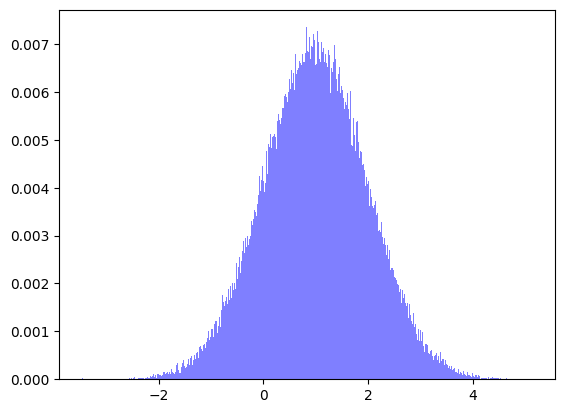

In [ ]:
hist = hist/np.sum(hist)
plt.bar(bins[:-1],hist,width=(max(bins) - min(bins))/len(bins), color="blue", alpha=0.5)

In [ ]:
plt.hist(distributions['Normal'],bins=500, density=True, alpha=0.5, label='Laplace', range=(-2,4))
plt.show()

NameError: name 'distributions' is not defined